# Сравнение трудоёмкостей алгоритмов поисков на графах

* DFS - Depth-First Search - Поиск в глубину
* BFS - Breadth-First Search - Поиск в ширину

Другими словами, измерение величины $\cfrac{\Theta_{DFS}}{\Theta_{BFS}}$

> В качестве среды разработки используем интерактивные блокноты [Jupyter <base target="_blank">](https://jupyter.org/), а код написан на языке [Julia <base target="_blank">](https://julialang.org/).

## Что будем делать?

Генерация случайного графа оказалась нетривиальной задачей. Чтобы как-то ограничить исследование, предлагаю следующие шаги:
1. Разобраться с инструментами;
1. Чётко формализовать алгоритм генерации графа;
2. Провести ряд вычислительных экспериментов, используя разные алгоритмы генерации с построением графиков зависимостей.

>### Отступление
>Человек ленив. Там, где можно немного упростить себе жизнь, это будет сделано. С этой целью было создано множество высокоуровневых языков программирования, Julia - один из таких. В её экосистеме написано множество библиотек, где описываются графы и вводятся распространённые алгоритмы на них.
>
>Человек ленив, а студент - тоже человек. Чем писать с нуля известные структуры (с риском ошибиться на ерунде), предлагаю сразу перейти к непосредственно поставленной задаче, доверившись, на этот раз, разработчикам используемых здесь библиотек.
---
## 1. Инструменты
Ниже приведены библиотеки языка Julia, которые нам понадобятся в процессе работы:
* Библиотека графов и алгоритмов на них
* Библиотеки рисования схем графов и графиков для отрисовки статистики

In [255]:
using Graphs
using GraphPlot
using Colors
using Compose
using Plots
using PlotThemes
using OnlineStats
using GraphRecipes
using LaTeXStrings
using ProgressMeter;

### Небольшой пример
Простенький демонстрационный граф, который предоставляет сама библиотека 

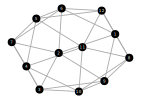

In [27]:
sample_12 = smallgraph(:icosahedral) # Здесь `:icosahedral` это значение-лейбл, служащее аргументом функции отрисовки

# Все аргументы рисовалки более-менее самообъясняющие:
gplot(   
    sample_12,
    nodefillc = "black",
    nodelabel = 1:nv(sample_12), # Именами вершин будут их номера
    nodelabelc = "white",
    edgestrokec = "darkgray",
)

Наряду со стандартным объявлением функции с помощью ключевого слова `function`, в Джулии в ходу сокращённая запись, более близкая к математической нотации. Сохраним понравившиеся настройки в виде новой функции одной переменной, в которую будем передавать только граф. В дальшейшем это облегчит синтаксические условности.

In [3]:
plot_graph(graph) = 
    gplot(   
        graph,
        nodefillc = "black",
        nodelabel = 1:nv(graph),
        nodelabelc = "white",
        edgestrokec = "darkgray",
        arrowlengthfrac = 0.07,
    );

### Алгоритм расчёта трудоёмкостей
На графе из примера покажем, как будем считать трудоёмкость алгоритмов. В используемой библиотеке это делаем следующим образом:
1. У `sample_12` выберем вершину (у нас вершины имеют уникальные номера);
2. Начиная с неё с помощью библиотечных функций построим орграфы, основанные на интересующих нас алгоритмах обхода;
3. Найдём геодезические расстояния до всех вершин - они вернутся в виде массива (вектора);
4. По индексу найдём в нём расстояние до интересующей нас вершины.

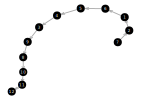

In [28]:
# Обход в глубину (начнём с 7-й вершины, почему бы и нет):
dfs_orgraph = dfs_tree(sample_12, 7)

plot_graph(dfs_orgraph)

In [29]:
# В массиве расстояний найдём по индексу расстояние до произвольного (другого) узла.
gdistances(dfs_orgraph, 7)[6] # До 6-го, например

3

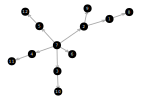

In [30]:
# Та же процедура с обходом в ширину:
bfs_orgraph = bfs_tree(sample_12, 7)

plot_graph(bfs_orgraph)

In [31]:
gdistances(bfs_orgraph, 7)[6]

1

>Отлично, теперь мы готовы составить процедуру сравнения двух алгоритмов. Замечу, что если выбранная вершина принадлежит другой компоненте связности, то `gdistances` вернёт наибольшее число типа `Int64`

...сначала написал я и реализовал довольно прямолинейную однопоточную функцию. Однако дальше с ростом размеров входных графов потребовалось немного её соптимизировать и этот процесс затянулся на два дня. Были перепробованы различные многопоточные реализации, без прибегания к совсем уж *obsqure* оптимизациям. Остановился на вот этой, которая в главном цикле вызывает макрос из модуля стандартной библиотеки `Threads`.

In [32]:
function mean_distance(graph, alg)
    n_vert = nv(graph)
    S = zeros(Int64, n_vert)
    n = zeros(Int64, n_vert)  
    Threads.@threads for i in 1:n_vert
        filtered = Iterators.filter(x-> 0<x<typemax(Int), gdistances(alg(graph, i), i))
        res = fit!(Sum(Int64), filtered)
        S[i] = res.sum
        n[i] = res.n
    end
    return mean(S ./ n)
end;

Обернём функцию выше в более высокоуровневую -- вызывающую функцию среднего расстояния с различными алгоритмами обхода:

In [33]:
function mean_ratio(graph)
    mean_distance(graph, dfs_tree) / mean_distance(graph, bfs_tree)
end;

In [34]:
@time mean_ratio(sample_12)

  0.313580 seconds (98.51 k allocations: 6.644 MiB, 7.65% gc time, 930.31% compilation time)


3.384259259259259

Проверим работу функции на нашем икосаэдре:

Отлично, первый результат получен! Конечно, можно и дальше оптимизировать алгоритм, но, в угоду простоте прототипирования, мы опустим сейчас какие-либо оптимизации, даже не будем аннотировать функции именами типов. Несмотря на это Julia может быть действительно эффективной, приближаясь по производительности к таким компилируемым языкам как C и Fortran. 

---
Перейдём, наконец, к объявленному вычислительному эксперименту. В пакете [Graphs.jl <base target="_blank">](https://juliagraphs.org/Graphs.jl/dev/) есть несколько алгоритмов генерации графов. Наперёд оценить, несколько один предпочтительнее другого не представляется возможным, так что попробуем несколько...

## 2. Алгоритмы генерации графов:

### 2.1 [Dorogovtsev and Mendes <base target="_blank">](https://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/)
Вот как он описан в документации пакета:

>`dorogovtsev_mendes(n)`
>
>Generate a random `n` vertex graph by the Dorogovtsev-Mendes method (with `n ≥ 3`).
>
>The Dorogovtsev-Mendes process begins with a triangle graph and inserts `n-3` additional vertices. Each time a vertex is added, a random edge is selected and the new vertex is connected to the two endpoints of the chosen edge. This creates graphs with many triangles and a high local clustering coefficient.
>
>It is often useful to track the evolution of the graph as vertices are added, you can access the graph from the `t`-th stage of this algorithm by accessing the first `t` vertices with `g[1:t]`.
>
>### References
>
  >* http://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/
  >* https://arxiv.org/pdf/cond-mat/0106144.pdf#page=24

Как видим, этот генератор имеет вссего один параметр - количество узлов. Посмотрим, что он генерирует:

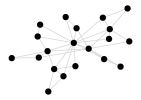

In [36]:
gplot(dorogovtsev_mendes(20), nodefillc = "black")

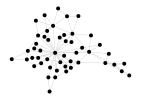

In [40]:
gplot(dorogovtsev_mendes(50), nodefillc = "black")

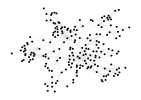

In [43]:
gplot(dorogovtsev_mendes(200), nodefillc = "black")

Замечу, что во всех достаточно больших сгенерированных графах (выше лишь несколько примеров) есть вершины с относительно высокой степенью (назовём их `центры`). Похоже, они - естественное следствие работы генератора: чем больше рёбер смежно с вершиной, тем вероятнее, что при следующем шаге генератора, на одну из них выпадет стать смежной новой вершине, а значит, степень такого `центра` снова повысится.

### 2.2 [Erdős–Rényi <base target="_blank">](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)
Этот алгоритм создаёт `n` вершин и пробрасывает между всеми парами выбранную вероятность `p`.

Посмотрим на его работу:

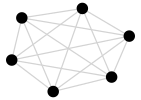

In [93]:
gplot(erdos_renyi(6, 1.0), nodefillc = "black")

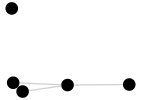

In [105]:
gplot(erdos_renyi(5, 0.6), nodefillc = "black")

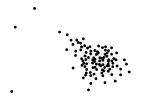

In [129]:
gplot(erdos_renyi(100, 0.03), nodefillc = "black")

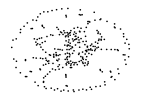

In [134]:
gplot(erdos_renyi(300, 0.005), nodefillc = "black")

Видим, что не все сгенерированные графы оказались полносвязными. Именно для этого случая в нашей функции есть фильтрация расстояний между вершинами разных компонент связности.

### 2.3 [Регулярный граф <base target="_blank">](https://en.wikipedia.org/wiki/Regular_graph)

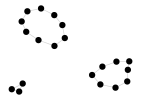

In [135]:
gplot(random_regular_graph(20, 2), nodefillc = "black")

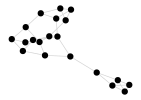

In [136]:
gplot(random_regular_graph(20, 3), nodefillc = "black")

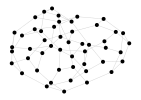

In [144]:
gplot(random_regular_graph(50, 3), nodefillc = "black")

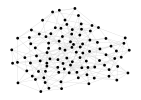

In [151]:
gplot(random_regular_graph(100, 5), nodefillc = "black")

Отдельно хотелось бы посмотреть на 2- и 3-мерные решётки:
### 2.3 Решётки

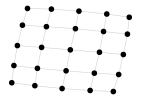

In [181]:
gplot(Graphs.grid([5,5]), nodefillc = "black")

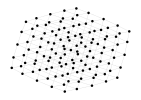

In [182]:
gplot(Graphs.grid([5,5,5]), nodefillc = "black")

Я упускаю много ещё разновидностей графов, но не могу обойти стороной деревья.
### 2.4 [Однородные (uniform) деревья  <base target="_blank">](https://en.wikipedia.org/wiki/Uniform_tree)

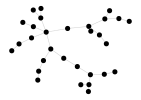

In [210]:
gplot(uniform_tree(30), nodefillc = "black")

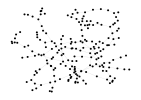

In [213]:
gplot(uniform_tree(200), nodefillc = "black")

### 2.5 Бинарные деревья

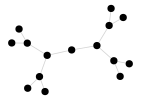

In [215]:
gplot(binary_tree(4), nodefillc = "black")

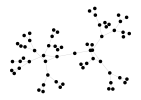

In [221]:
gplot(binary_tree(6), nodefillc = "black")

---
# 3. Эксперименты!
## 3.1 Dorogovtsev and Mendes
Сначала будем варьировать количество повторения для усреднения

In [227]:
function d_m_tests(xspace, repeats)
    results = Float32[]
    @showprogress for n in xspace # Количество вершин
        av = 0
        for i = 1:repeats # Количество повторений для усреднения
            g = dorogovtsev_mendes(n) # новый случайный граф на каждом шаге
            av += mean_ratio(g) # поиск всех путей - от каждой до каждой другой
        end
        push!(results, av/repeats)
    end
    return results
end;

In [228]:
@time begin
    dmt1 = d_m_tests(5:30, 10)
    dmt2 = d_m_tests(5:30, 25)
    dmt3 = d_m_tests(5:30, 50)
    dmt4 = d_m_tests(5:30, 100)
    dmt5 = d_m_tests(5:30, 200)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.792433 seconds (33.42 M allocations: 2.549 GiB, 26.97% gc time)


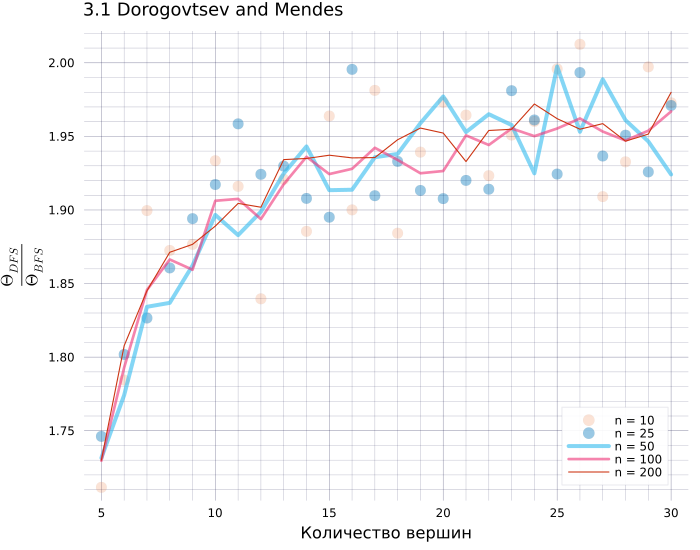

In [296]:
theme(:vibrant)
scatter(5:30, dmt1,
    title = "3.1 Dorogovtsev and Mendes",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = "n = 10",
    size = (700, 550),
    xaxis = "Количество вершин",
    yaxis = L"\frac{\Theta_{DFS}}{\Theta_{BFS}}",
    linewidth =8,
    alpha = 0.2,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )
scatter!(5:30, dmt2, label = "n = 25",linewidth =6, alpha = 0.4,)
plot!(5:30, dmt3, label = "n = 50",linewidth =4, alpha = 0.6,)
plot!(5:30, dmt4, label = "n = 100",linewidth = 2.7,  alpha = 0.6,)
plot!(5:30, dmt5, label = "n = 200",linewidth = 1.1, alpha = 1,)

In [304]:
savefig("plots/3.1.1.svg");

Далее зададим уже логарифмически убывающую плотность точек по горизонтали:

In [303]:
logspace = range(0.8, stop=3.1, length=50) .|> exp10 .|> ceil .|> Int;

In [251]:
@time dmt6 = d_m_tests(logspace, 300);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:49


469.624384 seconds (16.68 G allocations: 1.370 TiB, 58.13% gc time)


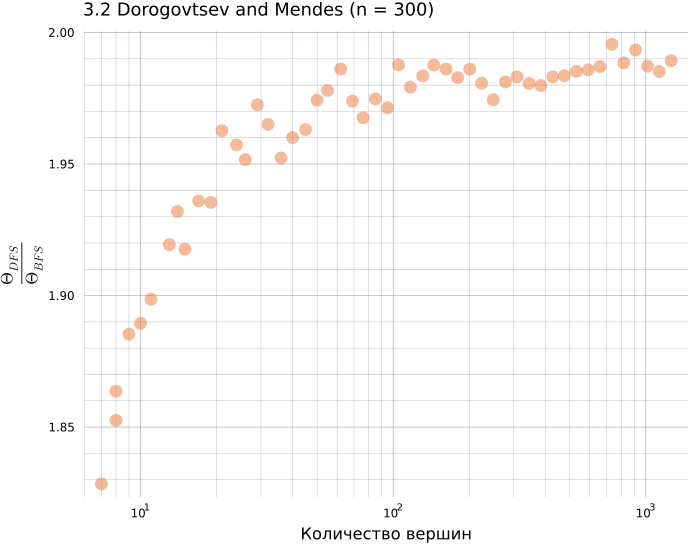

In [288]:
theme(:vibrant)
scatter(logspace, dmt6,
    title = "3.2 Dorogovtsev and Mendes (n = 300)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = false,
    size = (700, 550),
    xaxis = ("Количество вершин", :log),
    yaxis = L"\frac{\Theta_{DFS}}{\Theta_{BFS}}",
    markersize =7,
    alpha = 0.5,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

In [372]:
savefig("plots/3.1.2.svg");

### 3.2 Erdős–Rényi

In [377]:
function e_r_tests(nspace, pspace, repeats)
    results = Float32[]
    for n in nspace # Количество вершин
        @showprogress for p in pspace # Различные вероятности
            av = 0
            for i = 1:repeats # Количество повторений для усреднения
                g = erdos_renyi(n, p) # новый случайный граф на каждом шаге
                av += mean_ratio(g) # поиск всех путей - от каждой до каждой другой
            end
            push!(results, av/repeats)
        end
    end
    return results
end;

In [369]:
repeats = 1
nspace = 3:50:1000
ert1 = e_r_tests(nspace, [0.05], repeats)
ert2 = e_r_tests(nspace, [0.3], repeats)
ert3 = e_r_tests(nspace, [0.5], repeats)
ert4 = e_r_tests(nspace, [0.7], repeats)
ert5 = e_r_tests(nspace, [1.0], repeats);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


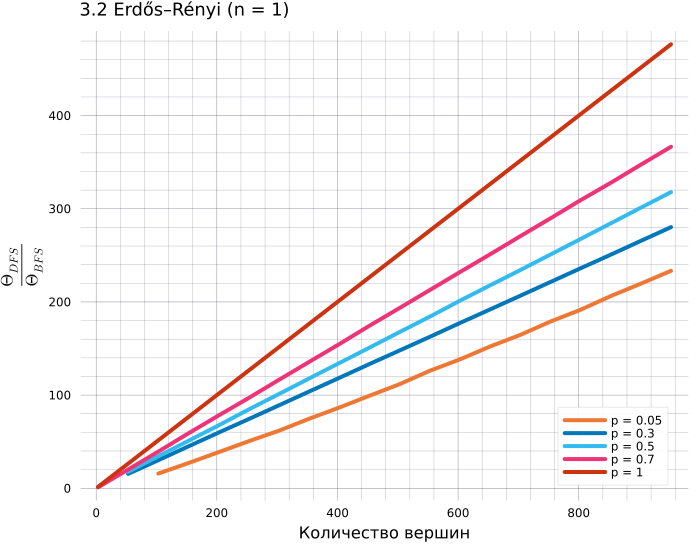

In [371]:
theme(:vibrant)
plot(nspace, ert1,
    title = "3.2.1 Erdős–Rényi (n = 1)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = "p = 0.05",
    size = (700, 550),
    xaxis = "Количество вершин",
    yaxis = L"\frac{\Theta_{DFS}}{\Theta_{BFS}}",
    linewidth = 4,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

plot!(nspace, ert2, label = "p = 0.3",linewidth = 4,)
plot!(nspace, ert3, label = "p = 0.5",linewidth = 4,)
plot!(nspace, ert4, label = "p = 0.7",linewidth = 4,)
plot!(nspace, ert5, label = "p = 1",linewidth = 4,)

In [373]:
savefig("plots/3.2.1.svg");

In [413]:
repeats = 1
nspace = [150]
# pspace = range(0.05, stop=1, length=50)
plogspace = range(-1.5, stop=0, length=50) .|> exp10
ert6 = e_r_tests([300], plogspace, repeats)
ert7 = e_r_tests([400], plogspace, repeats)
ert8 = e_r_tests([500], plogspace, repeats);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


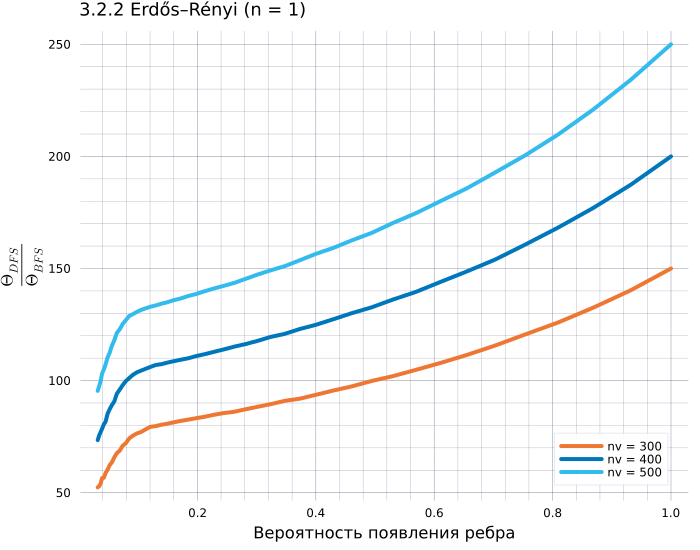

In [421]:
theme(:vibrant)
plot(plogspace, ert6,
    title = "3.2.2 Erdős–Rényi (n = 1)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = "nv = 300",
    size = (700, 550),
    xaxis = "Вероятность появления ребра",
    yaxis = L"\frac{\Theta_{DFS}}{\Theta_{BFS}}",
    linewidth = 4,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

plot!(plogspace, ert7, label = "nv = 400",linewidth = 4,)
plot!(plogspace, ert8, label = "nv = 500",linewidth = 4,)

In [422]:
savefig("plots/3.2.2.svg");

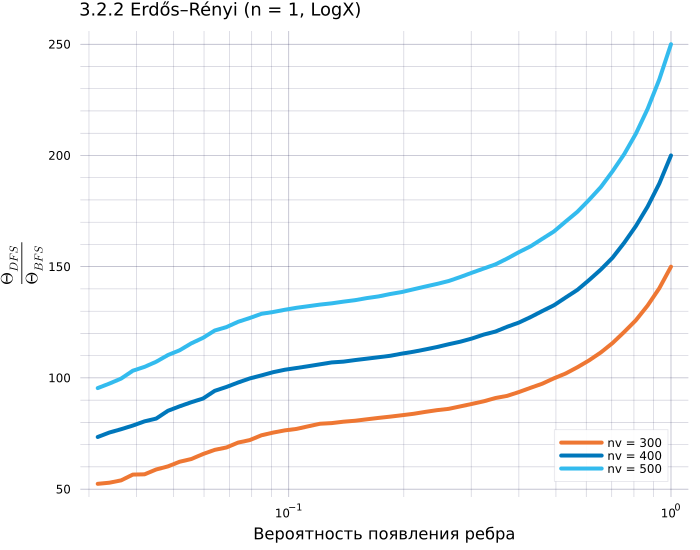

In [423]:
theme(:vibrant)
plot(plogspace, ert6,
    title = "3.2.2 Erdős–Rényi (n = 1, LogX)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = "nv = 300",
    size = (700, 550),
    xaxis = ("Вероятность появления ребра", :log),
    yaxis = L"\frac{\Theta_{DFS}}{\Theta_{BFS}}",
    linewidth = 4,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

plot!(plogspace, ert7, label = "nv = 400",linewidth = 4,)
plot!(plogspace, ert8, label = "nv = 500",linewidth = 4,)

In [424]:
savefig("plots/3.2.2LOG.svg");

### 3.3 Регулырный граф

In [426]:
function r_g_tests(nspace, kspace, repeats)
    results = Float32[]
    @showprogress for n in nspace # Количество вершин
        for k in kspace # Различные степени вершин
            av = 0
            for i = 1:repeats # Количество повторений для усреднения
                g = random_regular_graph(n, k) # новый случайный граф на каждом шаге
                av += mean_ratio(g) # поиск всех путей - от каждой до каждой другой
            end
            push!(results, av/repeats)
        end
    end
    return results
end;

In [428]:
repeats = 100
nspace = [150]
kspace = [4]#range(0.05, stop=1, length=50)
# plogspace = range(-1.5, stop=0, length=50) .|> exp10
rgt1 = r_g_tests(3:100, kspace, repeats)
# rgt2 = e_r_tests([400], kspace, repeats)
# rgt3 = e_r_tests([500], kspace, repeats);

LoadError: ArgumentError: the 0 <= k < n inequality must be satisfied